# Module 6 Lab 5 - Artificial Neural Network to predict readmission

## **NOTE: You need to use the Tensorflow CPU container for this notebook**

In this lab, we will attempt to predict readmissions using an artificial neural network, and compare the results to previous methods.

An artificial neural network (ANN) is meant to replicate the way in which it is thought that neurons in the brain interact with one another to form thoughts and memories. 

ANN's are comprised of multiple layers.  There is an input layer, one or more hidden layers, and an output layer.

<img src='../resources/artificial_neural_network.png'/>

In a dense network such as the one we will use, each node in one layer is connected to every node in the other layer.  Forward propogation is the process of computing the output of a node as the weighted sum of its inputs, which then become inputs to the next layer of the network.  These connection weights are adjusted during training by comparing the outputs produced by the network to the training examples.  Differences are back propogated through the network to adjust the weights between nodes, and the training process is ideally repeated until the loss (the difference between the model output and the expected output) is minimized.

In [1]:
import sys
!{sys.executable} -m pip install keras==2.3.1
!{sys.executable} -m pip install --upgrade "numpy>=1.2"

     |████████████████████████████████| 378kB 3.4MB/s eta 0:00:01
     |████████████████████████████████| 15.7MB 3.6MB/s eta 0:00:01
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [3]:
%matplotlib inline

## Apply transformations to our data
These are the same transformations as applied to the logistic regression model.  See Lab 1 for more explanations.

In [4]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('../resources/diabetes_readmission.csv')
display(data.head())

y = data['readmitted']
X = data[['discharge', 'age', 'race', 'admission_type', 'specialty', 'time_in_hospital', 'diag_1', 'A1Cresult', 'change']].copy()

scaler = StandardScaler()
X['time_in_hospital'] = scaler.fit_transform(X[['time_in_hospital']])

# create dummy variables
X = pd.concat([X, pd.get_dummies(X['age'], prefix = 'age', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['race'], prefix = 'race', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['admission_type'], prefix = 'admission_type', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['specialty'], prefix = 'specialty', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['diag_1'], prefix = 'diag_1', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['A1Cresult'], prefix = 'A1Cresult', drop_first=True)], axis=1)

# drop originals
X = X.drop(['age', 'race', 'admission_type', 'specialty', 'diag_1', 'A1Cresult'], axis=1)

# balance the classes
display(y.value_counts())

X_oversampled, y_oversampled = resample(X[y == 1], y[y == 1], replace=True, n_samples=X[y == 0].shape[0], random_state=42)

X = pd.DataFrame(np.vstack((X[y == 0], X_oversampled)), columns=X.columns)
y = np.hstack((y[y == 0], y_oversampled))

display(pd.Series(y).value_counts())

,readmitted,discharge,age,race,admission_type,specialty,time_in_hospital,diag_1,A1Cresult,change
0,1,0,0,1,1,0,8,8,0,1
1,0,0,0,1,1,4,2,8,0,0
2,0,1,2,1,1,2,4,8,2,0
3,0,0,2,1,1,2,3,8,3,1
4,0,0,0,0,1,2,5,8,0,0


0    60145
1     5813
Name: readmitted, dtype: int64

1    60145
0    60145
dtype: int64

## Train the Neural Network

This process will fit the data to a predefined neural network.  We are defining a network with three hidden layers of progressivly dimishing size, and an output layer consisting of one output (for binary classification). 

We use [Keras](https://www.tensorflow.org/api_docs/python/tf/keras/) and [KerasClassifier](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier) to make the model compatible with scikit learn.

We are using 200 epochs, and a batch size of 2048.  We have a fairly large dataset so using a larger batch size is OK.  We specify `shuffle=True` to shuffle the training data prior to the fit.


In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn import metrics

# train/test split, specify the seed for reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# create a metric function that can give us AUC at the end of each epoch
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def build_model(num_layers=3):
    model = Sequential()
    for l in range(num_layers, 0, -1):
        if l == num_layers:
            model.add(Dense(X_train.shape[1]*l, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_normal'))
        else:
            model.add(Dense(X_train.shape[1]*l, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = keras.optimizers.Adam(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', auc])
    
    return model

model = KerasClassifier(build_fn=build_model, epochs=200, batch_size=2048, verbose=2)

model.fit(X_train, y_train, shuffle=True)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 0.6912 - accuracy: 0.5607 - auc: 0.5452
Epoch 2/200
 - 0s - loss: 0.6735 - accuracy: 0.5861 - auc: 0.5867
Epoch 3/200
 - 0s - loss: 0.6714 - accuracy: 0.5874 - auc: 0.5984
Epoch 4/200
 - 0s - loss: 0.6698 - accuracy: 0.5900 - auc: 0.6043
Epoch 5/200
 - 0s - loss: 0.6675 - accuracy: 0.5924 - auc: 0.6085
Epoch 6/200
 - 0s - loss: 0.6665 - accuracy: 0.5937 - auc: 0.6116
Epoch 7/200
 - 0s - loss: 0.6647 - accuracy: 0.5970 - auc: 0.6144
Epoch 8/200
 - 0s - loss: 0.6629 - accuracy: 0.5993 - auc: 0.6169
Epoch 9/200
 - 0s - loss: 0.6613 - accuracy: 0.5998 - auc: 0.6189
Epoch 10/200
 - 0s - loss: 0.6591 - accuracy: 0.6027 - auc: 0.6212
Epoch 11/200
 - 0s - loss: 0.6578 - accuracy: 0.6024 - auc: 0.6230
Epoch 12/200
 - 0s - loss:

 - 0s - loss: 0.5977 - accuracy: 0.6481 - auc: 0.6925
Epoch 108/200
 - 0s - loss: 0.5971 - accuracy: 0.6495 - auc: 0.6927
Epoch 109/200
 - 0s - loss: 0.5966 - accuracy: 0.6511 - auc: 0.6929
Epoch 110/200
 - 0s - loss: 0.5960 - accuracy: 0.6499 - auc: 0.6932
Epoch 111/200
 - 0s - loss: 0.5957 - accuracy: 0.6514 - auc: 0.6935
Epoch 112/200
 - 0s - loss: 0.5953 - accuracy: 0.6522 - auc: 0.6937
Epoch 113/200
 - 0s - loss: 0.5955 - accuracy: 0.6514 - auc: 0.6939
Epoch 114/200
 - 0s - loss: 0.5952 - accuracy: 0.6509 - auc: 0.6942
Epoch 115/200
 - 0s - loss: 0.5956 - accuracy: 0.6517 - auc: 0.6944
Epoch 116/200
 - 0s - loss: 0.5959 - accuracy: 0.6495 - auc: 0.6947
Epoch 117/200
 - 0s - loss: 0.5950 - accuracy: 0.6516 - auc: 0.6949
Epoch 118/200
 - 0s - loss: 0.5943 - accuracy: 0.6519 - auc: 0.6951
Epoch 119/200
 - 0s - loss: 0.5949 - accuracy: 0.6517 - auc: 0.6954
Epoch 120/200
 - 0s - loss: 0.5951 - accuracy: 0.6518 - auc: 0.6956
Epoch 121/200
 - 0s - loss: 0.5952 - accuracy: 0.6531 - auc: 0

## Visualize and compare the results

accuracy 0.6358071565628052


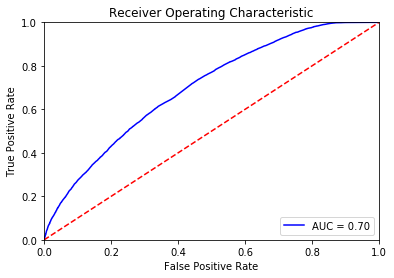

confusion matrix:
[[10168  9781]
 [ 4676 15071]]

classification report:
              precision    recall  f1-score   support

           0       0.68      0.51      0.58     19949
           1       0.61      0.76      0.68     19747

    accuracy                           0.64     39696
   macro avg       0.65      0.64      0.63     39696
weighted avg       0.65      0.64      0.63     39696



In [6]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

print('accuracy', model.score(X_test, y_test))

probs = model.predict_proba(X_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred = model.predict(X_test)

cmatrix = confusion_matrix(y_test, y_pred)
print('confusion matrix:')
print(cmatrix)
print('\nclassification report:')
print(classification_report(y_test, y_pred))

## Results
The ROC and Accuracy are higher than logistic regression, but lower than decision trees and random forest, by a small margin. 

The precision is also lower than decision tree and random forest for both positive and negative cases.

However, a close examination of the output from the training epochs indicate a progressively improving AUC, though the accuracy and the loss are not changing as much.  It is possible that the neural network has not converged and could benefit from more time spent in training, by increasing the epochs.
